In [2]:
import numpy as np
import pandas as pd
import torch
import os, glob
import random, csv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models
from    torch import optim, nn
import  visdom
import  torchvision


device = torch.device('cuda')
torch.manual_seed(1234)

In [39]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # xw+b
        self.fc1 = nn.Linear(32*32*3, 256)
        #self.fc2 = nn.Linear(512, 256)
        #self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        # x: [b, 3, 32, 32]
        # h1 = relu(xw1+b1)
        x = x.view(-1,3072)
        
        x = F.relu(self.fc1(x))
        # h2 = relu(h1w2+b2)
        #x = F.relu(self.fc2(x))
        # h3 = h2w3+b3
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [7]:
'''
自写resnet模型
'''

class ResBlk1(nn.Module):
    """
    resnet block
    """
    def __init__(self, ch_in, ch_out, stride=1):
        """
        :param ch_in:
        :param ch_out:
        """
        super(ResBlk1, self).__init__()

        # we add stride support for resbok, which is distinct from tutorials.
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=2, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=2, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )


    def forward(self, x):
        """
        :param x: [b, ch, h, w]
        :return:
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # short cut.
        # extra module: [b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = self.extra(x) + out
        out = F.relu(out)
        
        return out


class ResBlk2(nn.Module):
    """
    resnet block
    """

    def __init__(self, ch_in, ch_out, stride=1):
        """

        :param ch_in:
        :param ch_out:
        """
        super(ResBlk2, self).__init__()

        # we add stride support for resbok, which is distinct from tutorials.
        #(ground((8-2)/4) + 1 = 2)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=2, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(ch_out)
        #self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=4, stride=1, padding=0)
        #self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
                
            )


    def forward(self, x):
        """

        :param x: [b, ch, h, w]
        :return:
        """
        out = F.relu(self.bn1(self.conv1(x)))
        #out = self.bn2(self.conv2(out))
        # short cut.
        # extra module: [b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = F.relu(self.extra(x)) + out
        out = F.relu(out)
        
        return out

class ResBlk3(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super(ResBlk3, self).__init__()
        # we add stride support for resbok, which is distinct from tutorials.
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(ch_out)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out  
    
class ResNet9(nn.Module):

    def __init__(self,num_class):
        super(ResNet9, self).__init__()
        # [b, 3, 32, 32] => [b, 64, 16 ,16]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64)
        )
        # followed 4 blocks
        # [b, 64, 16, 16] => [b, 128, 8 ,8]
        self.blk1 = ResBlk1(64, 128, stride=2)
        # [b, 128, 8, 8] => [b, 256, 2, 2]
        self.blk2 = ResBlk2(128, 256, stride=4)
        # # [b, 256, 2, 2] => [b, 512, 2, 2]
        self.blk3 = ResBlk3(256, 512, stride=1)
        # # [b, 512, h, w] => [b, 1024, h, w]
        #self.blk4 = ResBlk(512, 512, stride=2)
        # # [b, 512, 2, 2] => [b, 2048]
        self.outlayer = nn.Linear(2048, num_class)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # [b, 64, h, w] => [b, 1024, h, w]
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        #x = self.blk4(x)
        #print('after conv:', x.shape) #[b, 512, 2, 2]
        # [b, 512, h, w] => [b, 512, 1, 1]
        #x = nn.AvgPool2d(2, stride=2)
        #x = F.avg_pool2d(x, kernel_size = 2)
        #print('after pool:', x.shape)
        x = torch.flatten(x, 1)
        #print('after flatten:', x.shape)
        x = self.outlayer(x)

        return x

In [52]:
'''
改进自写的resnet9_a模型
'''

class ResBlk1(nn.Module):
    """
    resnet block
    """
    def __init__(self, ch_in, ch_out, stride=1):
        """
        :param ch_in:
        :param ch_out:
        """
        super(ResBlk1, self).__init__()

        # we add stride support for resbok, which is distinct from tutorials.
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=2, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=2, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )


    def forward(self, x):
        """
        :param x: [b, ch, h, w]
        :return:
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # short cut.
        # extra module: [b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = self.extra(x) + out
        out = F.relu(out)
        
        return out


class ResBlk2(nn.Module):
    """
    resnet block
    """

    def __init__(self, ch_in, ch_out, stride=1):
        """

        :param ch_in:
        :param ch_out:
        """
        super(ResBlk2, self).__init__()

        # we add stride support for resbok, which is distinct from tutorials.
        #(ground((8-2)/4) + 1 = 2)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=2, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(ch_out)
        #self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=4, stride=1, padding=0)
        #self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            # [b, ch_in, h, w] => [b, ch_out, h, w]
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
                
            )


    def forward(self, x):
        """

        :param x: [b, ch, h, w]
        :return:
        """
        out = F.relu(self.bn1(self.conv1(x)))
        #out = self.bn2(self.conv2(out))
        # short cut.
        # extra module: [b, ch_in, h, w] => [b, ch_out, h, w]
        # element-wise add:
        out = F.relu(self.extra(x)) + out
        out = F.relu(out)
        
        return out

class ResBlk3(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super(ResBlk3, self).__init__()
        # we add stride support for resbok, which is distinct from tutorials.
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, padding=0)
        self.bn1 = nn.BatchNorm2d(ch_out)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out  
    
class ResNet9_a(nn.Module):

    def __init__(self,num_class):
        super(ResNet9_a, self).__init__()
        # [b, 3, 32, 32] => [b, 64, 16 ,16]
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64)
        )
        # followed 4 blocks
        # [b, 64, 16, 16] => [b, 128, 8 ,8]
        self.blk1 = ResBlk1(64, 128, stride=2)
        # [b, 128, 8, 8] => [b, 256, 2, 2]
        self.blk2 = ResBlk2(128, 256, stride=4)
        # # [b, 256, 2, 2] => [b, 512, 2, 2]
        self.blk3 = ResBlk3(256, 512, stride=1)
        # # [b, 512, h, w] => [b, 1024, h, w]
        #self.blk4 = ResBlk(512, 512, stride=2)
        # # [b, 512, 2, 2] => [b, 2048]
        #self.avgpool2D = nn.AvgPool2d(kernel_size=2)
        self.outlayer = nn.Linear(512, num_class)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # [b, 64, h, w] => [b, 1024, h, w]
        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        #x = self.blk4(x)
        #print('after conv:', x.shape) #[b, 512, 2, 2]
        # [b, 512, h, w] => [b, 512, 1, 1]
        #x = nn.AvgPool2d(2, stride=2)
        x = F.avg_pool2d(x, kernel_size = 2)
        #print('after pool:', x.shape)
        #x = self.avgpool2D(x)
        x = torch.flatten(x, 1)
        #print('after flatten:', x.shape)
        x = self.outlayer(x)

        return x

In [8]:
'''
数据预处理部分
'''

class urban_original(Dataset):

    def __init__(self, root, resize, mode):
        super(urban_original, self).__init__()

        self.root = root
        self.resize = resize

        self.name2label = {} # "sq...":0
        for name in sorted(os.listdir(os.path.join(root))):
            if not os.path.isdir(os.path.join(root, name)):
                continue

            self.name2label[name] = len(self.name2label.keys())

        # print(self.name2label)

        # image, label
        self.images, self.labels = self.load_csv('images.csv')

        if mode=='train': # 56%
            self.images = self.images[:int(0.7 * 0.8 * len(self.images))]
            self.labels = self.labels[:int(0.7 * 0.8 * len(self.labels))]
        elif mode=='val': # 14% = 56%->70%
            self.images = self.images[int(0.7 * 0.8 * len(self.images)):int(0.7*len(self.images))]
            self.labels = self.labels[int(0.7 * 0.8 * len(self.labels)):int(0.7*len(self.labels))]
        else: # 30% = 70%->100%
            self.images = self.images[int(0.7*len(self.images)):]
            self.labels = self.labels[int(0.7*len(self.labels)):]


    def load_csv(self, filename):

        if not os.path.exists(os.path.join(self.root, filename)):
            images = []
            for name in self.name2label.keys():
                # 'pokemon\\mewtwo\\00001.png
                images += glob.glob(os.path.join(self.root, name, '*.png'))
                images += glob.glob(os.path.join(self.root, name, '*.jpg'))
                images += glob.glob(os.path.join(self.root, name, '*.jpeg'))

            # 1167, 'pokemon\\bulbasaur\\00000000.png'
            print(len(images), images)

            random.shuffle(images)
            with open(os.path.join(self.root, filename), mode='w', newline='') as f:
                writer = csv.writer(f)
                for img in images: # 'pokemon\\bulbasaur\\00000000.png'
                    name = img.split(os.sep)[-2]
                    label = self.name2label[name] -1
                    # 'pokemon\\bulbasaur\\00000000.png', 0
                    writer.writerow([img, label])
                print('writen into csv file:', filename)

        # read from csv file
        images, labels = [], []
        with open(os.path.join(self.root, filename)) as f:
            reader = csv.reader(f)
            for row in reader:
                # 'pokemon\\bulbasaur\\00000000.png', 0
                img, label = row
                label = int(label)

                images.append(img)
                labels.append(label)

        assert len(images) == len(labels)

        return images, labels

    def __len__(self):

        return len(self.images)

    def __getitem__(self, idx):
        # idx~[0~len(images)]
        # self.images, self.labels
        # img: 'pokemon\\bulbasaur\\00000000.png'
        # label: 0
        img, label = self.images[idx], self.labels[idx]

        tf = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'), # string path= > image data
            transforms.Resize((int(self.resize), int(self.resize))),
            #transforms.RandomRotation(15),
            #transforms.CenterCrop(self.resize),
            transforms.ToTensor()
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                     std=[0.229, 0.224, 0.225])
        ])
        
        img = tf(img)
        label = torch.tensor(label)


        return img, label

In [102]:
'''
resnet训练
'''
import  torch
from    torch import optim, nn
import  visdom
import  torchvision
from    torch.utils.data import DataLoader
from    torch.nn import functional as F
#from    pokemon import Pokemon
# from    resnet import ResNet18
#from    torchvision.models import resnet18

#from    utils import Flatten

batchsz = 32
lr = 1e-3
epochs = 10

device = torch.device('cuda')
torch.manual_seed(1234)


train_db = urban_original('data/stft_window2048', 32, mode='train')
val_db = urban_original('data/stft_window2048', 32,mode='val')
test_db = urban_original('data/stft_window2048', 32,mode='test')
train_loader = DataLoader(train_db, batch_size=batchsz, shuffle=True,
                          num_workers=4,drop_last = True)
val_loader = DataLoader(val_db, batch_size=batchsz, num_workers=2,drop_last = True)
test_loader = DataLoader(test_db, batch_size=batchsz, num_workers=2,drop_last = True)


viz = visdom.Visdom()

def evalute(model, loader):
    model.eval()
    
    correct = 0
    total = len(loader.dataset)

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total

#def main():


model = ResNet9(10).to(device)
#trained_model = resnet18(pretrained=False)
#model = nn.Sequential(*list(trained_model.children())[:-1], #[b, 512, 1, 1]
                      #Flatten(), # [b, 512, 1, 1] => [b, 512]
                      #nn.Linear(512, 10)
                      #).to(device)
#x = torch.randn(2, 3, 32,32)
#model
#print(model(x).shape)


#optimizer_o = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.lr_scheduler.ExponentialLR(optimizer_o, gamma=0.98)
optimizer = optim.Adam(model.parameters(), lr=lr)
criteon = nn.CrossEntropyLoss()


best_acc, best_epoch = 0, 0
global_step = 0
viz.line([0], [-1], win='loss', opts=dict(title='loss'))
viz.line([0], [-1], win='val_acc', opts=dict(title='val_acc'))
for epoch in range(epochs):

    for step, (x,y) in enumerate(train_loader):

        # x: [b, 3, 224, 224], y: [b]
        x, y = x.to(device), y.to(device)

        model.train()
        logits = model(x)
        loss = criteon(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #viz.line([loss.item()], [global_step], win='loss', update='append')
        global_step += 1

    if epoch % 1 == 0:

        val_acc = evalute(model, val_loader)
        if val_acc> best_acc:
            best_epoch = epoch
            best_acc = val_acc

            torch.save(model.state_dict(), 'data/stft_window2048/best_resnet9_stft_window2048_weight.mdl')

            viz.line([val_acc], [global_step], win='val_acc', update='append')


print('best acc:', best_acc, 'best epoch:', best_epoch)

model.load_state_dict(torch.load('data/stft_window2048/best_resnet9_stft_window2048_weight.mdl'))
print('loaded from ckpt!')

test_acc = evalute(model, test_loader)
print('test acc:', test_acc)





#if __name__ == '__main__':
    #main()

Setting up a new session...


best acc: 0.974803664921466 best epoch: 8
loaded from ckpt!
test acc: 0.9735857699060997


In [103]:
'''
转换resnet模型为onnx
'''
model.eval()
batch_size = 32
input_shape = (3, 32, 32) 
x = torch.randn(batch_size, *input_shape).to(device)
export_onnx_file = "data/stft_window2048/best_resnet9_stft_window2048.onnx"
torch.onnx.export(model,
                    x,
                    export_onnx_file,
                    opset_version=10,
                    do_constant_folding=True,
                    input_names=["input"],
                    output_names=["output"],
                    dynamic_axes={"input":{0:"batch_size"},
                                    "output":{0:"batch_size"}})



In [104]:
'''
检查resnet转换的onnx模型是否有误
'''
import onnx
import onnxruntime
x_onnx_test = np.ones((3,32,32))*66
x_onnx_test.astype('int32')
x_onnx_test = torch.from_numpy(x_onnx_test)
x_onnx_test = x_onnx_test.float()
x_onnx_test = x_onnx_test.view((1,3,32,32)).to(device)
torch_out = model(x_onnx_test)
# 使用 ONNX 的 API 检查 ONNX 模型
onnx_model = onnx.load("data/stft_window2048/best_resnet9_stft_window2048.onnx")
onnx.checker.check_model(onnx_model)
# 使用 ONNX Runtime 运行模型
ort_session = onnxruntime.InferenceSession("data/stft_window2048/best_resnet9_stft_window2048.onnx")
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
 #构建输入并得到输出
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x_onnx_test)}
ort_outs = ort_session.run(None, ort_inputs)
ort_out = ort_outs[0]
# --------------------------------------比较ONNX Runtime 和 PyTorch 的结果
np.testing.assert_allclose(to_numpy(torch_out), ort_out, rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [105]:
'''
按预处理的方式将图片转换到csv便于eran验证
'''
def zhuanhuan_pyt_or(image_path = 'data/stft_window2048/images.csv'):
    meta = pd.read_csv(image_path,names=['add','target'], header=0)
    recordings = meta[0:100]
    address = recordings['add']
    flag = recordings['target']
    matrix = []
    for index in range(len(recordings)):
        p = address[index]
        t = flag[index]        
        #读出图像，完成预处理，并与其标签合并
        tor = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.ToPILImage()
        ])
        x = tor(p)
        x = np.array(x)
        #x = x.reshape(3,32,32).transpose((0,2,1)).reshape(-1)
        x = x.reshape(-1)
        x = np.hstack((t, x)).astype(np.int32)
        matrix.append(list(x))
    save = pd.DataFrame(matrix)
    save.to_csv('stft_window2048_cifar10_test.csv', index=False, header=False)

zhuanhuan_pyt_or()

In [13]:
'''
提取一个图像来进行试验
'''
tor1 = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((32,32)),
            transforms.ToTensor()
        ])
x_image_test = tor1('data/mfcc_nmfcc_20/air_conditioner/0000.png')
x_image_test = x_image_test

In [14]:
x_image_test

tensor([[[0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.9686],
         [0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.9647],
         [0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.9647],
         ...,
         [0.7725, 0.7804, 0.7686,  ..., 0.7725, 0.7725, 0.7647],
         [0.5451, 0.5608, 0.5412,  ..., 0.5137, 0.5137, 0.5059],
         [0.3294, 0.3569, 0.3294,  ..., 0.2706, 0.2706, 0.2667]],

        [[0.7294, 0.7373, 0.7255,  ..., 0.7255, 0.7216, 0.7255],
         [0.7333, 0.7333, 0.7333,  ..., 0.7294, 0.7294, 0.7333],
         [0.7333, 0.7333, 0.7373,  ..., 0.7333, 0.7373, 0.7412],
         ...,
         [0.2196, 0.2471, 0.2118,  ..., 0.2118, 0.2118, 0.1961],
         [0.2784, 0.3098, 0.2745,  ..., 0.2392, 0.2392, 0.2235],
         [0.4392, 0.4745, 0.4431,  ..., 0.3608, 0.3569, 0.3529]],

        [[0.6196, 0.6314, 0.6196,  ..., 0.6196, 0.6118, 0.6196],
         [0.6235, 0.6314, 0.6275,  ..., 0.6275, 0.6235, 0.6275],
         [0.6275, 0.6314, 0.6314,  ..., 0.6314, 0.6314, 0.

In [15]:
'''
resnet结果
'''
model(x_image_test.view((1,3,32,32)).to(device))

tensor([[ 4.4616,  2.3745, -2.0151, -7.5216, -5.0965, -2.6762, -5.8650, -4.1185,
         -2.2336, -0.9104]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
'''
fnn结果
'''
model(x_image_test.view((1,3,32,32)).to(device))

In [21]:
'''
试试cifar10的resnet
'''
a = np.genfromtxt('work/ERAN/data/yuan_cifar10_test.csv', delimiter=',').astype(np.uint8)[:,1:][0].reshape(32,32,3)
a = Image.fromarray(a.astype('uint8'), 'RGB')
a.save('cifar10_test.jpg')

tor_cifar10_test = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((32,32)),
            transforms.ToTensor()
        ])
x_cifar10_image_test = tor_cifar10_test('cifar10_test.jpg')
model(x_cifar10_image_test.view((1,3,32,32)).to(device))

tensor([[ -9.8407, -18.6878, -19.8498, -21.2595,  13.4326, -53.6592, -30.3426,
         -21.8941,  -0.7256,  -9.3661]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [38]:
'''
试试cifar10的fnn
'''
a = np.genfromtxt('work/ERAN/data/yuan_cifar10_test.csv', delimiter=',').astype(np.uint8)[:,1:][0].reshape(32,32,3)
a = Image.fromarray(a.astype('uint8'), 'RGB')
a.save('cifar10_test.jpg')

tor_cifar10_test = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((32,32)),
            transforms.ToTensor()
        ])
x_cifar10_image_test = tor_cifar10_test('cifar10_test.jpg')
model(x_cifar10_image_test.view((1,3,32,32)).to(device))

tensor([[-2.3107,  3.6733,  1.7601,  1.3950,  0.9522, -9.5842, -7.4693, -5.6212,
         -5.3350,  0.2805]], device='cuda:0', grad_fn=<AddmmBackward>)

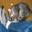

In [19]:
a

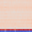

In [49]:
b = np.genfromtxt('shishi5.csv', delimiter=',').astype(np.uint8)[:,1:][0].reshape(32,32,3)
b = Image.fromarray(b.astype('uint8'), 'RGB')
b

In [45]:
tor_cifar10_csv = transforms.Compose([
            lambda x:Image.open(x).convert('RGB'),
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.ToPILImage()
        ])
x_cifar10_csv = tor_cifar10_csv('cifar10_test.jpg')
x_cifar10_csv = np.array(x_cifar10_csv)
x_cifar10_csv = x_cifar10_csv.reshape(3,32,32).transpose((1,2,0)).reshape(-1)
x_cifar10_csv = np.hstack((0, x_cifar10_csv)).astype(np.int32)

In [46]:
x_cifar10_csv

array([  0, 167, 154, ..., 151, 150, 129], dtype=int32)

In [28]:
kong = []
kong.append(list(x_cifar10_csv))

In [30]:
save = pd.DataFrame(kong)

In [31]:
save

0     1     2     3     4     5     6     7     8     9     ...  3063  \
0     0   167   154   148   107   135   139    47   144   143  ...   125   

   3064  3065  3066  3067  3068  3069  3070  3071  3072  
0   168   197    27   146   151    79   151   150   129  

[1 rows x 3073 columns]

In [32]:
save.to_csv('cifar10_test.csv', index=False, header=False)

In [87]:
'''
生成音频csv
'''
def urban_w_csv(root,filename): #创建esc10(增强后的)的csv文件
    # 创建数字编码表
    name2label = {}  # "sq...":0
    # 遍历根目录下的子文件夹，并排序，保证映射关系固定
    for name in sorted(os.listdir(os.path.join(root))):
        # 跳过非文件夹
        if not os.path.isdir(os.path.join(root, name)):
            continue
        # 给每个类别编码一个数字
        name2label[name] = len(name2label.keys())
        
    # 从csv文件返回images,labels列表
    # root:数据集根目录，filename:csv文件名， name2label:类别名编码表
    if not os.path.exists(os.path.join(root, filename)):
        # 如果csv文件不存在，则创建
        images = []
        for name in name2label.keys(): # 遍历所有子目录，获得所有的图片
            # 只考虑后缀为png,jpg,jpeg的图片：'pokemon\\mewtwo\\00001.png
            images += glob.glob(os.path.join(root, name, '*.wav'))
            #images += glob.glob(os.path.join(root, name, '*.jpg'))
            #images += glob.glob(os.path.join(root, name, '*.jpeg'))
        # 打印数据集信息：1167, 'pokemon\\bulbasaur\\00000000.png'
        print(len(images), images)
        random.shuffle(images) # 随机打散顺序
        # 创建csv文件，并存储图片路径及其label信息
        with open(os.path.join(root, filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            for img in images:  # 'pokemon\\bulbasaur\\00000000.png'
                name = img.split(os.sep)[-2]
                label = name2label[name] -1
                # 'pokemon\\bulbasaur\\00000000.png', 0
                writer.writerow([img, label])
            print('written into csv file:', filename)

    # 此时已经有csv文件，直接读取
    images, labels = [], []
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:
            # 'pokemon\\bulbasaur\\00000000.png', 0
            img, label = row
            label = int(label)
            images.append(img)
            labels.append(label) 
    # 返回图片路径list和标签list
    return images, labels,name2label

In [88]:
'''
生成stft图像
'''
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os, glob
from PIL import Image
import random,csv
import pathlib

def urban_w_to_i_stft(root_image = 'data/stft_window1024', root_csv = 'data/UrbanSound8K/audio_augmented',ass_window = 1024):#将esc50的音频转化为stft谱图
    #recordings = pd.read_csv('/content/drive/MyDrive/ESC50/ESC-50-master/meta/esc50.csv')

    #esc_10_recordings = recordings[recordings.esc10 == True]

    #e_10 = esc_10_recordings.reset_index()

    music,labels,name2label= urban_w_csv(root_csv, 'urban_music.csv')
    #若还没有root文件夹，建一个


    if not os.path.isdir(os.path.join(root_image)):
        pathlib.Path(f'{root_image}').mkdir(parents=True, exist_ok=True)

    #取出esc10的标签类别,并建立文件夹
    #for g in e_10.category.values:
    #pathlib.Path(f'{root}/{g}_1').mkdir(parents=True, exist_ok=True)
    #for k in ['0.75', '0.9', '1.15', '1.5']:
    #for g in e_10.category.values:
    #pathlib.Path(f'{root}/{g}_{k}').mkdir(parents=True, exist_ok=True)
    for g in name2label.keys():
        pathlib.Path(f'{root_image}/{g}').mkdir(parents=True, exist_ok=True)

    #预设fold5为evaluation集
    #e_10_test = e_10[e_10.fold == 5]
    #e_10_train = e_10[e_10.fold != 5]
    #y_train = e10_train.target.values
    #y_test = e10_test.target.values

    #得到esc10的category
    category = list(name2label.keys())

    #得到x_train和x_test
    for index in range(len(music)):
        recording = music[index]
        flag_tmp = labels[index]
        flag = category[flag_tmp] #返回category
        signal = librosa.load(recording, sr=44100)[0]
        S = np.abs(librosa.stft(signal,n_fft = ass_window))
        spec = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max),
                            y_axis='log', x_axis='time')

    #category = meta()[meta().filename == recording].category.values[0]

    #ax.imshow(spec, origin='lower', interpolation=None, cmap='viridis', aspect=1.1)
    #ax.set_title(f'{category} - {recording}', fontsize=11)
    #ax.get_yaxis().set_visible(False)
    #ax.get_xaxis().set_visible(False)
        plt.axes().set_aspect('auto')
        plt.axis('off')
        plt.savefig(f'{root_image}/{flag}/{index:04d}.png',bbox_inches='tight',dpi=72,pad_inches = 0)
        plt.clf()

In [89]:
for i in [512,1024,2048]:
    urban_w_to_i_stft(root_image = f'data/stft_window{i}', root_csv = 'data/UrbanSound8K/audio_augmented',ass_window = i)

/home/featurize/work/.local/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/featurize/work/.local/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/featurize/work/.local/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning:

<Figure size 432x288 with 0 Axes>

In [92]:
'''
生成图像csv
'''
def load_csv_image(root, filename, name2label):
    

    # 读取Label信息
    # [file1,file2,], [3,1]

    # 从csv文件返回images,labels列表
    # root:数据集根目录，filename:csv文件名， name2label:类别名编码表
    if not os.path.exists(os.path.join(root, filename)):
        # 如果csv文件不存在，则创建
        images = []
        for name in name2label.keys(): # 遍历所有子目录，获得所有的图片
            # 只考虑后缀为png,jpg,jpeg的图片：esc10\\flag\\0001.png'
            images += glob.glob(os.path.join(root, name, '*.png'))
            images += glob.glob(os.path.join(root, name, '*.jpg'))
            images += glob.glob(os.path.join(root, name, '*.jpeg'))
        # 打印数据集信息：1167, 'esc10\\flag\\0001.png'
        print(len(images), images)
        random.shuffle(images) # 随机打散顺序
        # 创建csv文件，并存储图片路径及其label信息
        with open(os.path.join(root, filename), mode='w', newline='') as f:
            writer = csv.writer(f)
            for img in images:  # 'esc10\\flag\\0000.png', 0
                name = img.split(os.sep)[-2]
                label = name2label[name]
                # 'esc10\\flag\\0000.png', 0
                writer.writerow([img, label])
            print('written into csv file:', filename)

    # 此时已经有csv文件，直接读取
    images, labels = [], []
    with open(os.path.join(root, filename)) as f:
        reader = csv.reader(f)
        for row in reader:
            # 'esc10\\flag\\0000.png', 0
            img, label = row
            label = int(label)
            images.append(img)
            labels.append(label) 
    # 返回图片路径list和标签list
    return images, labels

def write_csv_image(root):
    # 创建数字编码表
    name2label = {}  # "sq...":0
    # 遍历根目录下的子文件夹，并排序，保证映射关系固定
    for name in sorted(os.listdir(os.path.join(root))):
        # 跳过非文件夹
        if not os.path.isdir(os.path.join(root, name)):
            continue
        # 给每个类别编码一个数字
        name2label[name] = len(name2label.keys())

    # 读取Label信息
    # [file1,file2,], [3,1]
    images, labels = load_csv_image(root, 'images.csv', name2label)


In [93]:
for i in [512,1024,2048]:
    write_csv_image(f'data/stft_window{i}')

43660 ['data/stft_window512/.ipynb_checkpoints/7830.png', 'data/stft_window512/.ipynb_checkpoints/24288.png', 'data/stft_window512/.ipynb_checkpoints/10780.png', 'data/stft_window512/.ipynb_checkpoints/27003.png', 'data/stft_window512/.ipynb_checkpoints/36010.png', 'data/stft_window512/.ipynb_checkpoints/11160.png', 'data/stft_window512/.ipynb_checkpoints/16437.png', 'data/stft_window512/.ipynb_checkpoints/26817.png', 'data/stft_window512/.ipynb_checkpoints/23139.png', 'data/stft_window512/.ipynb_checkpoints/40237.png', 'data/stft_window512/.ipynb_checkpoints/17545.png', 'data/stft_window512/.ipynb_checkpoints/10107.png', 'data/stft_window512/.ipynb_checkpoints/5123.png', 'data/stft_window512/.ipynb_checkpoints/43272.png', 'data/stft_window512/.ipynb_checkpoints/19439.png', 'data/stft_window512/.ipynb_checkpoints/20173.png', 'data/stft_window512/.ipynb_checkpoints/14077.png', 'data/stft_window512/.ipynb_checkpoints/10889.png', 'data/stft_window512/.ipynb_checkpoints/36747.png', 'data/s

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

